# 2D Finite Volume Meshes

In [71]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

## Part 1: Node coordinates

The `.node` files are very simple. Each line contains the x and y coordinate of a node.

In [72]:
nodeCoordinates = np.loadtxt("meshes/blade0.node", skiprows=1)
print(nodeCoordinates[:10])

[[-27.000049    -1.237215  ]
 [-27.000049     0.46096024]
 [-27.000049     2.4792453 ]
 [-27.000049     4.87798158]
 [-27.000049     7.728885  ]
 [-23.6831689   -1.237215  ]
 [-23.35562958   0.68898222]
 [-22.96704546   2.97778661]
 [-22.50590944   5.69755045]
 [-21.95854535   8.92951054]]


These nodes be plotted very simply using the standard `plot` function from matplotlib. 
Just be sure to turn off the line connecting the points.

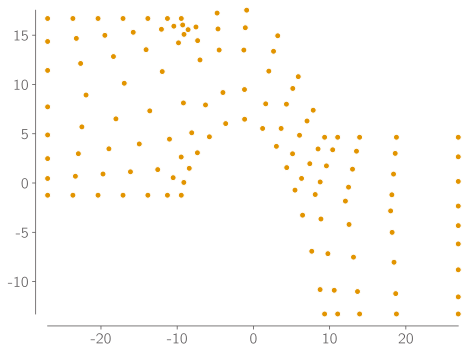

In [73]:
fig, ax = plt.subplots()
ax.plot(nodeCoordinates[:, 0], nodeCoordinates[:, 1], "o", clip_on=False, label="Nodes")
niceplots.adjust_spines(ax)

## Part 2: Node connectivity

The `.elem` file describes how the nodes are connected to form the triangular cells.
Each row in the file contains the indices of the three nodes that form a triangle.

In [74]:
# MAKE SURE TO SUBTRACT 1 FROM THE ELEMENT CONNECTIVITY BECAUSE PYTHON IS 0 INDEXED
nodeConnectivity = np.loadtxt("meshes/blade0.elem", skiprows=1, dtype=int) - 1
print(nodeConnectivity[:10])

[[ 0  5  1]
 [ 5  6  1]
 [ 1  6  2]
 [ 6  7  2]
 [ 2  7  3]
 [ 7  8  3]
 [ 3  8  4]
 [ 8  9  4]
 [ 5 10  6]
 [10 11  6]]


We can use this information to plot the mesh cells.

The naive way to do this would be to loop through each cell, then loop through each node in the cell and plot a line from that node to the next node in the cell.

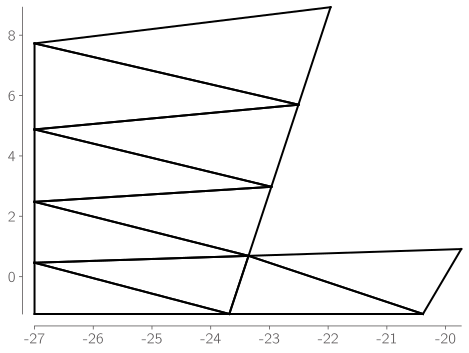

In [75]:
# Naive plotting method
fig, ax = plt.subplots()
for cellNum in range(10):
    for edgeNum in range(3):
        node1 = nodeConnectivity[cellNum, edgeNum]
        node2 = nodeConnectivity[cellNum, (edgeNum + 1) % 3]
        ax.plot(
            [nodeCoordinates[node1, 0], nodeCoordinates[node2, 0]],
            [nodeCoordinates[node1, 1], nodeCoordinates[node2, 1]],
            "-",
            color="k",
            clip_on=False,
        )
niceplots.adjust_spines(ax)

Fortunately, matplotlib has a function that automates this process: `triplot`.

`triplot` takes in arrays of x and y coordinates, followed by another argument that describes the node connectivity, such as our node connectivity array.

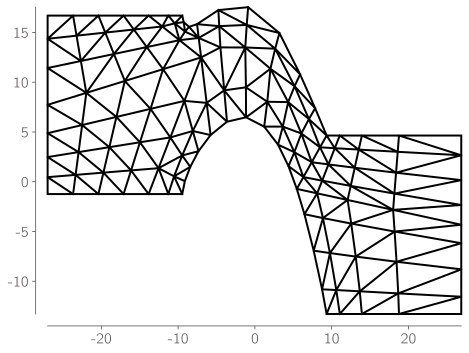

In [76]:
# Smarter plotting method
fig, ax = plt.subplots()
ax.triplot(nodeCoordinates[:, 0], nodeCoordinates[:, 1], nodeConnectivity, color="k", clip_on=False)
niceplots.adjust_spines(ax)

### Computing cell quantities

Often, we want to plot some quantity that is defined on the cells, such as the Mach number or density.
Matplotlib has another function called `tripcolor` that can be used to plot such quantities.
`tripcolor` takes in the same arguments as `triplot`, but also takes in an array of values that are defined on the cells or nodes.

The code below demonstrates `tripcolor` by plotting the cell areas.

In [77]:
def computeCellAreas(nodeCoordinates, nodeConnectivity):
    numCells = nodeConnectivity.shape[0]
    cellAreas = np.zeros(numCells)
    node1 = nodeConnectivity[:, 0]
    node2 = nodeConnectivity[:, 1]
    node3 = nodeConnectivity[:, 2]
    x1 = nodeCoordinates[node1, 0]
    x2 = nodeCoordinates[node2, 0]
    x3 = nodeCoordinates[node3, 0]
    y1 = nodeCoordinates[node1, 1]
    y2 = nodeCoordinates[node2, 1]
    y3 = nodeCoordinates[node3, 1]

    cellAreas[:] = np.abs(0.5 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2)))

    return cellAreas


cellAreas = computeCellAreas(nodeCoordinates, nodeConnectivity)

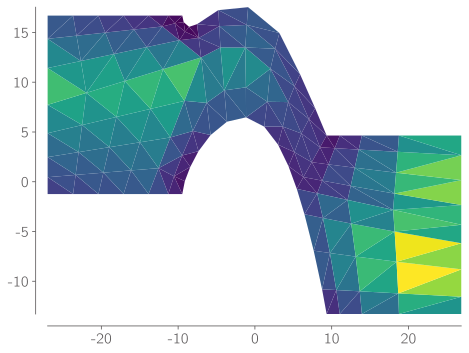

In [78]:
fig, ax = plt.subplots()
ax.tripcolor(nodeCoordinates[:, 0], nodeCoordinates[:, 1], nodeConnectivity, cellAreas, cmap="viridis")
niceplots.adjust_spines(ax)

We can then call other plotting methods to plot other things on top of the mesh, such as the cell edges.

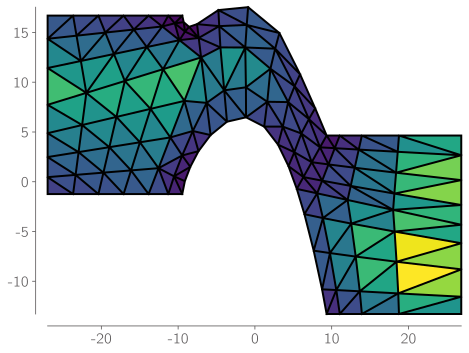

In [79]:
ax.triplot(nodeCoordinates[:, 0], nodeCoordinates[:, 1], nodeConnectivity, color="k", clip_on=False)
fig

## Cell connectivity

The `.connect` file describes how the cells in the mesh are connected to each other.
Each row in the file contains the 3 indices of the neighbouring cells.
A negative index indicates that an edge is on the boundary of the domain, and the value of the negative number denotes the type of boundary condition.

The ordering of the neighbouring cell indices is linked to the ordering of the nodes in each cell.
The first neighbouring cell index corresponds to the neighbour on the edge of the triangle opposite the first node in the cell.


In [80]:
cellConnectivity = np.loadtxt("meshes/blade0.connect", skiprows=8, dtype=int)
# Subtract 1 from the cell connectivity because Python is 0 indexed, but not for the negative values that represent the boundary conditions
cellConnectivity[cellConnectivity >= 0] -= 1

Let's use the cell connectivity information to plot lines between a few of the cells and their neighbours.

In [81]:
def computeCellCentroids(nodeCoordinates, nodeConnectivity):
    numCells = nodeConnectivity.shape[0]
    cellCentroids = np.zeros((numCells, 2))
    node1 = nodeConnectivity[:, 0]
    node2 = nodeConnectivity[:, 1]
    node3 = nodeConnectivity[:, 2]
    x1 = nodeCoordinates[node1, 0]
    x2 = nodeCoordinates[node2, 0]
    x3 = nodeCoordinates[node3, 0]
    y1 = nodeCoordinates[node1, 1]
    y2 = nodeCoordinates[node2, 1]
    y3 = nodeCoordinates[node3, 1]

    cellCentroids[:, 0] = (x1 + x2 + x3) / 3
    cellCentroids[:, 1] = (y1 + y2 + y3) / 3
    return cellCentroids


cellCentroids = computeCellCentroids(nodeCoordinates, nodeConnectivity)

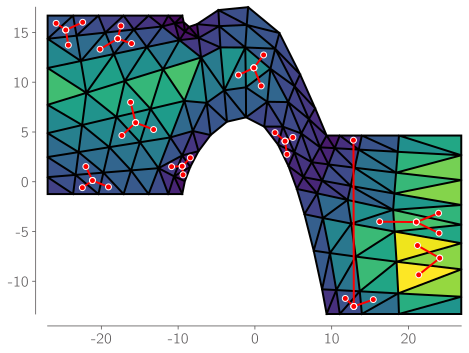

In [82]:
np.random.seed(0)

for ii in range(10):
    # Choose a random cell index and get that cell's centroid
    cellIndex = np.random.randint(0, cellConnectivity.shape[0])
    centroid = cellCentroids[cellIndex]
    # Plot a line between the centroid of this cell and the centroid of each of its neighbors, excluding boundaries.
    for jj in range(3):
        neighborIndex = cellConnectivity[cellIndex, jj]
        if neighborIndex >= 0:
            neighborCentroid = cellCentroids[neighborIndex]
            ax.plot([centroid[0], neighborCentroid[0]], [centroid[1], neighborCentroid[1]], "r-o")
fig

## Simple mesh test case

When you write your mesh processing code, it's a good idea to come up with a simple test case that you can use to verify that your code is working correctly.

Here we construct such a case using 4 nodes and 2 triangles.

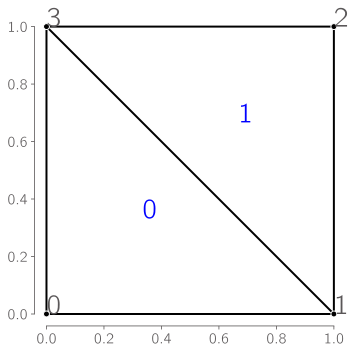

In [83]:
nodeCoordinates = np.array([[0, 0], [1, 0], [1, 1], [0, 1]])
nodeConnectivity = np.array([[0, 1, 3], [1, 2, 3]])

cellAreas = computeCellAreas(nodeCoordinates, nodeConnectivity)
cellCentroids = computeCellCentroids(nodeCoordinates, nodeConnectivity)

fig, ax = plt.subplots()
ax.triplot(nodeCoordinates[:, 0], nodeCoordinates[:, 1], nodeConnectivity, color="k", clip_on=False)
ax.plot(nodeCoordinates[:, 0], nodeCoordinates[:, 1], "o", color="k", clip_on=False)

# Label the nodes with their indices
for ii in range(len(nodeCoordinates)):
    ax.annotate(str(ii), (nodeCoordinates[ii, 0], nodeCoordinates[ii, 1]), fontsize=28)

# Label the cells with their indices
for ii in range(len(cellCentroids)):
    ax.annotate(str(ii), (cellCentroids[ii, 0], cellCentroids[ii, 1]), color="b", fontsize=28)

niceplots.adjust_spines(ax)
ax.set_aspect("equal")

To compute fluxes, we need data about the edges in the mesh.

It is useful to split the edges into two sets; interior edges and boundary edges.

Interior edges are those that are shared by two cells, while boundary edges are only part of one cell, because they lie on the boundary of the domain.

Here I am manually creating the data structures that describe the edges, in your project you will need to write code to do this for any mesh.

In [84]:
# each row in this array contains, the indices of the nodes that make up the edge, followed by the index of the left cell and the index of the right cell
# [startNode, endNode, leftCell, rightCell]
interiorEdges = np.array([[1, 3, 0, 1]])

# Each row in the boundary edges array contains the indices of the nodes that make up the edge, followed by the index of the cell that the edge is on and finally the boundary condition type
# [startNode, endNode, (left)Cell, boundaryConditionType]
boundaryEdges = np.array([[3, 0, 0, -1], [0, 1, 0, -1], [2, 3, 1, -2], [1, 2, 1, -2]])

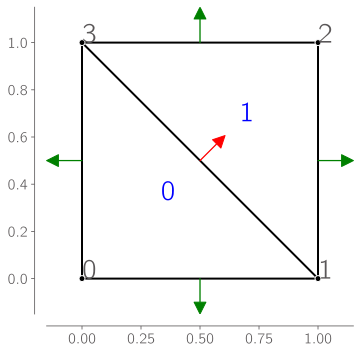

In [85]:
for ii, edge in enumerate(interiorEdges):
    node1 = nodeCoordinates[edge[0]]
    node2 = nodeCoordinates[edge[1]]
    centroid = 0.5 * (node1 + node2)
    edgeVector = node2 - node1
    edgeLength = np.linalg.norm(edgeVector)
    normal = np.array([edgeVector[1], -edgeVector[0]]) / edgeLength

    ax.arrow(
        centroid[0],
        centroid[1],
        normal[0] * 0.1,
        normal[1] * 0.1,
        head_width=0.05,
        head_length=0.05,
        fc="r",
        ec="r",
    )

for ii, edge in enumerate(boundaryEdges):
    node1 = nodeCoordinates[edge[0]]
    node2 = nodeCoordinates[edge[1]]
    centroid = 0.5 * (node1 + node2)
    edgeVector = node2 - node1
    edgeLength = np.linalg.norm(edgeVector)
    normal = np.array([edgeVector[1], -edgeVector[0]]) / edgeLength

    ax.arrow(
        centroid[0],
        centroid[1],
        normal[0] * 0.1,
        normal[1] * 0.1,
        head_width=0.05,
        head_length=0.05,
        fc="g",
        ec="g",
    )
fig

### Freestream preservation test

The freestream presentation test works by setting all the boundary conditions and cell states to be equal to a freestream state.

We then check 2 things:
- The initial residual should be zero
- The residual should remain at zero (and the cell states remain at the freestream) as we march forward in time

Here we perform these tests in a very hardcoded way, your project code will be able to do the same thing in a much more general way.

In [86]:
from flux import FluxFunction

cellPerimeter = 2 + np.sqrt(2)


def computeTestCaseResidual(U0, U1, UBoundary, gamma):
    R = np.zeros((2, 4))
    waveSpeeds = np.zeros(2)

    # Left Boundary
    edgeLength = 1
    normal = np.array([-1, 0])
    F, smag = FluxFunction(U0, UBoundary, gamma, normal)
    R[0] += F * edgeLength
    waveSpeeds[0] += smag * edgeLength / cellPerimeter

    # Bottom Boundary
    edgeLength = 1
    normal = np.array([0, -1])
    F, smag = FluxFunction(U0, UBoundary, gamma, normal)
    R[0] += F * edgeLength
    waveSpeeds[0] += smag * edgeLength / cellPerimeter

    # Right Boundary
    edgeLength = 1
    normal = np.array([1, 0])
    F, smag = FluxFunction(U1, UBoundary, gamma, normal)
    R[1] += F * edgeLength
    waveSpeeds[1] += smag * edgeLength / cellPerimeter

    # Top Boundary
    edgeLength = 1
    normal = np.array([0, 1])
    F, smag = FluxFunction(U1, UBoundary, gamma, normal)
    R[1] += F * edgeLength
    waveSpeeds[1] += smag * edgeLength / cellPerimeter

    # Interior edge
    edgeLength = np.sqrt(2)
    ndiag = np.array([1, 1]) / np.sqrt(2)
    F, smag = FluxFunction(U0, U1, gamma, ndiag)
    R[0] += F * edgeLength
    R[1] -= F * edgeLength
    waveSpeeds[0] += smag * edgeLength / cellPerimeter
    waveSpeeds[1] += smag * edgeLength / cellPerimeter

    return R, waveSpeeds

For the first freestream preservation test, we make up a freestream state, set it in both cells, and then check that the residual is zero.

In [87]:
freeStreamState = np.array([0.5, 0.4, 0.8, 2.6])

U0 = freeStreamState.copy()
U1 = freeStreamState.copy()

gamma = 1.4

R, _ = computeTestCaseResidual(U0, U1, freeStreamState, gamma)
print(R)

[[ 0.00000000e+00 -2.22044605e-16  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00]]


And now we will run a simulation for a few thousand timesteps, and check that the residual remains zero and the state doesn't significantly change.

In [88]:
numTimeSteps = 2000

CFL = 1.0
cellDiameter = 0.3
cellAreas = computeCellAreas(nodeCoordinates, nodeConnectivity)

for _ in range(numTimeSteps):
    R, waveSpeeds = computeTestCaseResidual(U0, U1, freeStreamState, gamma)
    dt = CFL * cellDiameter / waveSpeeds

    U0 -= dt[0] * R[0] / cellAreas[0]
    U1 -= dt[1] * R[1] / cellAreas[1]

print(f"Initial state = {freeStreamState}")
print("Final states:")
print(f"U0 = {U0}")
print(f"U1 = {U1}")

print("Final Residuals:")
print(R)

Initial state = [0.5 0.4 0.8 2.6]
Final states:
U0 = [0.5 0.4 0.8 2.6]
U1 = [0.5 0.4 0.8 2.6]
Final Residuals:
[[ 0.00000000e+00  2.22044605e-16  0.00000000e+00  0.00000000e+00]
 [-2.22044605e-16 -4.44089210e-16  0.00000000e+00 -8.88178420e-16]]
